In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import sys
import json
import subprocess
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#
# system_name='mazama'
system_name='Sherlock_Owners'
groups_fname=None

#groups_fname='mazama_groups.json'
#
#data_file_name='data/sacct_mazama_out_2.out'
#data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_mazama_out_20200506a.out'
#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200622.out'
data_file_name = 'data/sacct_owners_out_3500489.out'
#
# as small(ish) test data set:
#data_file_name = 'data/sacct_mazama_20200701_20200718.out'

#data_file_name = 'data/serc_sacct_2020_06_29.out'

output_path = 'output/{}_HPC_analytics'.format(system_name)
#output_path = 'output/HPC_analytics'

In [3]:
load_pickle = True
dump_pickle = True
max_rows = None
#max_rows = 1000
n_cpu=4
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
#
if load_pickle:
    with open(pkl_name, 'rb') as fin:
        sacct_obj=pickle.load(fin)
    #
else:
    sacct_obj = hpc_lib.SACCT_data_handler(data_file_name=data_file_name,
                    max_rows=max_rows, n_cpu=n_cpu, verbose=1)
    #
    if dump_pickle:
        with open(pkl_name, 'wb') as fout:
                #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
                out_pkl = pickle.dump(sacct_obj, fout)
#

In [4]:
print("States: ", [s for s in set(sacct_obj.jobs_summary['State']) if not "CANCELLED" in s] )
#
#dT = .5
ix_pr  = sacct_obj.jobs_summary['State']=='PREEMPTED'
ix_npr = sacct_obj.jobs_summary['State']!='PREEMPTED'
ix_cpl = sacct_obj.jobs_summary['State']=='COMPLETED'
#
#
N_pr  = len(sacct_obj.jobs_summary[ix_pr])
N_npr = len(sacct_obj.jobs_summary[ix_npr])
print('*** preempted: {} vs {}, a/b={}'.format(N_pr, N_npr, N_pr/N_npr))


States:  ['TIMEOUT', 'NODE_FAIL', 'OUT_OF_MEMORY', 'REQUEUED', 'PREEMPTED', 'COMPLETED', 'RUNNING', 'FAILED', 'PENDING']
*** preempted: 80966 vs 3920991, a/b=0.020649371549182338


In [5]:
print('** ', sacct_obj.data.dtype.names)
#print('** ', [s for s in set(sacct_objmazama.data['State']) if 'PR' in s])
#
preempted = (sacct_obj.jobs_summary[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
                              'End', 'Elapsed']][ix_pr])
preempted = preempted[numpy.argsort(preempted['JobID'])]
#
print('*** len: ', len(preempted))

#jsp = sacct_obj.

#print('** ', preempted[numpy.argsort(preempted['JobID'])][0:10])
#print('** ', preempted[0:10])
#pr_working = preempted[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
#                              'End', 'Elapsed']]
#
compl = sacct_obj.jobs_summary[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
                              'End', 'Elapsed']][ix_npr]

#compl = sacct_obj.jobs_summary[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
#                              'End', 'Elapsed']][sacct_obj.jobs_summary['State']!='PREEMPTED']

print(preempted[0:10])
print('** ', preempted.dtype.names)
#
print('** len(completed): ', len(compl))



**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'ReqTRES', 'AllocTRES', 'JobID_parent')
*** len:  80966
[('1002304', 1, 1, 737567.485     , 737567.49084491, 737567.50112269, 0.01021991)
 ('1003246_420', 1, 1, 737567.50872685, 737567.51943287, 737567.52925926, 0.00976852)
 ('1003246_421', 1, 1, 737567.50872685, 737567.51943287, 737567.52943287, 0.0099537 )
 ('1003246_426', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_427', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_428', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_429', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_430', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.

### Preemption probabilities
- As a function of time
- Elapsed runtime, preceding preemption
- Count number $N(<t)$ for jobs that are (not) preempted, $P=N_p(t)/N_c(t)$

Preempted: t_90: 11.1631
Preempted: P(1hr): 0.6155485018402787
Completed: t_90: 6.03662986111111
Completed: P(1hr): 0.755282784377725
** N_completed: 3920991
** N_pr: 80966
** P(re):  0.020231601688873717
***  49.278611111111104
** **  (2, 49)
*** ***
[0.72825955 0.79778096 0.83275419 0.85155468 0.86856202 0.87917019
 0.89008296 0.89557982 0.90150873 0.90610477 0.91158215 0.91503349
 0.91864676 0.92064655 0.92249291 0.92434927 0.92626011 0.92784785
 0.92924418 0.9307577 ]
[0.74049893 0.81210984 0.8480686  0.86754626 0.88505986 0.89608708
 0.90733468 0.9131384  0.91933068 0.92413188 0.92978567 0.93338169
 0.93716388 0.9393041  0.9412854  0.94327895 0.94529098 0.94698492
 0.94850669 0.95010418]


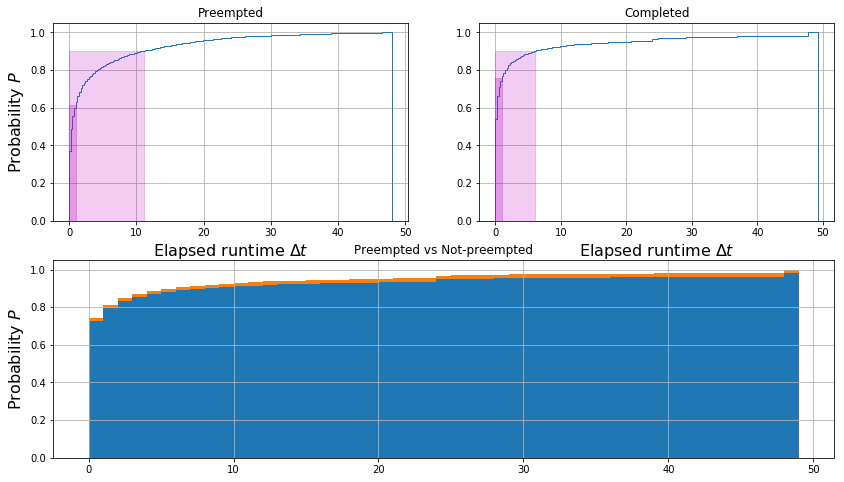

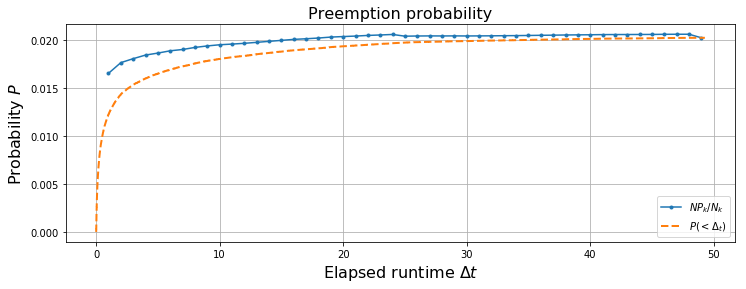

In [6]:
fg = plt.figure(figsize=(14,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
ax3 = fg.add_subplot('212')
#
ax1.set_ylabel('Probability $P$', size=16)
ax3.set_ylabel('Probability $P$', size=16)
ax1.set_xlabel('Elapsed runtime $\Delta t$', size=16)
ax2.set_xlabel('Elapsed runtime $\Delta t$', size=16)
#
hhs=[]

for nm, dta,ax in [("Preempted", preempted, ax1), ("Completed", compl, ax2)]:
    hh = ax.hist(dta['Elapsed']*24., bins=200, cumulative=True,
                  density=True, zorder=5, histtype='step')
    hhs+=[hh]
    #
    y_90=.9*numpy.max(hh[0])
    k_90=numpy.searchsorted(hh[0], y_90)
    #x_90 = .5*(hh[1][k_90]+hh[1][k_90+1])
    x_90 = numpy.mean(hh[1][k_90:k_90+2])
    ax.fill_between([0., x_90], [0.,0.], y_90, color='m', alpha=.2, zorder=11)
    #
    # 1 hour:
    dt=1.
    k1h = numpy.searchsorted(hh[1], dt)
    y1h = numpy.mean(hh[0][k1h-2:k1h])
    ax.fill_between([0., 1.], 0., y1h, color='m', alpha=.25, zorder=10 )

    ax.grid()
    ax.set_title("{}".format(nm))
    #
    print('{}: t_90: {}'.format(nm, x_90))
    print('{}: P(1hr): {}'.format(nm, y1h/numpy.max(hh[0])))
    #
print('** N_completed: {}'.format(len(compl)))
print('** N_pr: {}'.format(len(preempted)))
#
print('** P(re): ', len(preempted)/(len(preempted)+len(compl)))
#
# TODO: total probability distribution of preemption. so basically we want to add the cumulative histograms
#. of preempted and completed.To do that, we have to interpolate the two sets on to the same x-axis.
# a quick estimator is to just multiply by P(preempt).
#ax3.plot()
#print('** ', type(hh[0]))
max_bin = numpy.max([numpy.max(preempted['Elapsed']), numpy.max(compl['Elapsed'])])*24
print('*** ', max_bin)
bins = numpy.arange(0., max_bin,1.)
hhh = ax3.hist([compl['Elapsed']*24., preempted['Elapsed']*24.], bins=bins,
              histtype='barstacked', density=True, log=False, cumulative=True,
               bottom=0.0*numpy.ones(-1+len(bins)))
ax3.grid()
ax3.set_title('Preempted vs Not-preempted')
#
print('** ** ', numpy.shape(hhh[0]))
# note: if we're using the "barstacked" histogram, the second series is S2 = s1+s2.
#
P_pr=1.- (hhh[0][0]/hhh[0][1])
#
fg2=plt.figure(figsize=(12,4))
ax4 = fg2.add_subplot('111')
ax4.set_title('Preemption probability', size=16)
ax4.set_ylabel('Probability $P$', size=16)
ax4.set_xlabel('Elapsed runtime $\Delta t$', size=16)

#ax4a = ax4.twinx()
#
ax4.plot(hhh[1][1:], P_pr, ls='-', marker='.', label='$NP_k/N_k$')
# ax4.plot(bins[1:], hhh[0][0])
# ax4a.plot(bins[1:], hhh[0][1])
ax4.grid()
#
# let's just build this cum-prob manually:
dt_Np = numpy.zeros( (len(sacct_obj.jobs_summary),2))
#for t,s in sacct_obj.jobs_summary[numpy.argsort(sacct_mazama.jobs_summary['Elapsed'])]:
#    it s=='PREEMPTED'

ix_s = numpy.argsort(sacct_obj.jobs_summary['Elapsed'])
dt_Np[:,0] = sacct_obj.jobs_summary['Elapsed'][ix_s]
dt_Np[:,1] = numpy.cumsum((sacct_obj.jobs_summary['State'][ix_s]=='PREEMPTED').astype(int))
#
# /float(len(dt_Np))
ax4.plot(dt_Np[:,0]*24., dt_Np[:,1]/float(len(dt_Np)), ls='--', lw=2., label='$P(<\Delta_t)$')
#
# the hist and just counting cumulative measures match, if they're not normalized. just using the top
# of the stacked histogram doesnot seem to work quite right... because they are slightly different measures
# of the probability of PreEmption. gotta think about that a bit...
#hh = ax4.hist(preempted['Elapsed']*24., bins=100, cumulative=True,
#                  density=False, zorder=5, histtype='step')
ax4.legend(loc=0)
#
print('*** ***')
print(hhh[0][0][0:20])
print(hhh[0][1][0:20])

### Preemption prorabilities (total CPU time):
- Same as above, but compute as a function of totalcput time, not just elapsed.

In [7]:
print('*** ', sacct_obj.jobs_summary.dtype.names)

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'ReqTRES', 'AllocTRES', 'JobID_parent')


/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Preempted: t_90: 18.230999999999998
Preempted: P(1hr): nan
Completed: t_90: 19.202333333333332
Completed: P(1hr): nan
** N_completed: 3920991
** N_pr: 80966
** P(re):  0.020231601688873717
***  49.278611111111104
** **  (2, 49)
*** ***
[0.72825955 0.79778096 0.83275419 0.85155468 0.86856202 0.87917019
 0.89008296 0.89557982 0.90150873 0.90610477 0.91158215 0.91503349
 0.91864676 0.92064655 0.92249291 0.92434927 0.92626011 0.92784785
 0.92924418 0.9307577 ]
[0.74049893 0.81210984 0.8480686  0.86754626 0.88505986 0.89608708
 0.90733468 0.9131384  0.91933068 0.92413188 0.92978567 0.93338169
 0.93716388 0.9393041  0.9412854  0.94327895 0.94529098 0.94698492
 0.94850669 0.95010418]


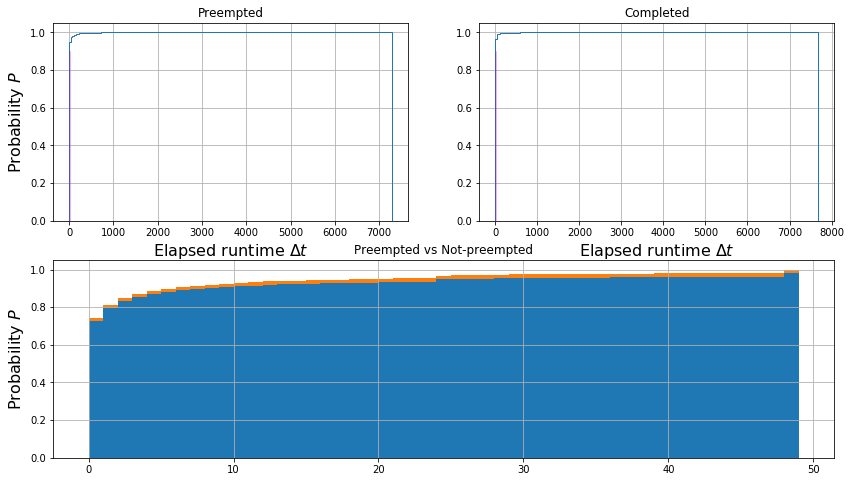

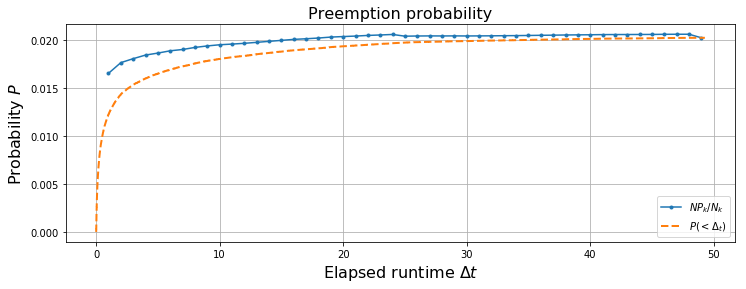

In [8]:
fg = plt.figure(figsize=(14,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
ax3 = fg.add_subplot('212')
#
ax1.set_ylabel('Probability $P$', size=16)
ax3.set_ylabel('Probability $P$', size=16)
ax1.set_xlabel('Elapsed runtime $\Delta t$', size=16)
ax2.set_xlabel('Elapsed runtime $\Delta t$', size=16)
#
hhs=[]

for nm, dta,ax in [("Preempted", preempted, ax1), ("Completed", compl, ax2)]:
    # NOTE: TotalCPU, UserCPU, and SystemCPU -- until recently, were recorded as strings.
    #. they should the esame type as Elapsed, so we've replaced the processor function
    #. to convert them to float. BUT, until then, use Elapsed*NCPUS.
    #
    hh = ax.hist(dta['Elapsed']*dta['NCPUS']*24., bins=200, cumulative=True,
                  density=True, zorder=5, histtype='step')
    hhs+=[hh]
    #
    y_90=.9*numpy.max(hh[0])
    k_90=numpy.searchsorted(hh[0], y_90)
    #x_90 = .5*(hh[1][k_90]+hh[1][k_90+1])
    x_90 = numpy.mean(hh[1][k_90:k_90+2])
    ax.fill_between([0., x_90], [0.,0.], y_90, color='m', alpha=.2, zorder=11)
    #
    # 1 hour:
    dt=1.
    k1h = numpy.searchsorted(hh[1], dt)
    y1h = numpy.mean(hh[0][k1h-2:k1h])
    ax.fill_between([0., 1.], 0., y1h, color='m', alpha=.25, zorder=10 )

    ax.grid()
    ax.set_title("{}".format(nm))
    #
    print('{}: t_90: {}'.format(nm, x_90))
    print('{}: P(1hr): {}'.format(nm, y1h/numpy.max(hh[0])))
    #
print('** N_completed: {}'.format(len(compl)))
print('** N_pr: {}'.format(len(preempted)))
#
print('** P(re): ', len(preempted)/(len(preempted)+len(compl)))
#
# TODO: total probability distribution of preemption. so basically we want to add the cumulative histograms
#. of preempted and completed.To do that, we have to interpolate the two sets on to the same x-axis.
# a quick estimator is to just multiply by P(preempt).
#ax3.plot()
#print('** ', type(hh[0]))
max_bin = numpy.max([numpy.max(preempted['Elapsed']), numpy.max(compl['Elapsed'])])*24
print('*** ', max_bin)
bins = numpy.arange(0., max_bin,1.)
hhh = ax3.hist([compl['Elapsed']*24., preempted['Elapsed']*24.], bins=bins,
              histtype='barstacked', density=True, log=False, cumulative=True,
               bottom=0.0*numpy.ones(-1+len(bins)))
ax3.grid()
ax3.set_title('Preempted vs Not-preempted')
#
print('** ** ', numpy.shape(hhh[0]))
# note: if we're using the "barstacked" histogram, the second series is S2 = s1+s2.
#
P_pr=1.- (hhh[0][0]/hhh[0][1])
#
fg2=plt.figure(figsize=(12,4))
ax4 = fg2.add_subplot('111')
ax4.set_title('Preemption probability', size=16)
ax4.set_ylabel('Probability $P$', size=16)
ax4.set_xlabel('Elapsed runtime $\Delta t$', size=16)

#ax4a = ax4.twinx()
#
ax4.plot(hhh[1][1:], P_pr, ls='-', marker='.', label='$NP_k/N_k$')
# ax4.plot(bins[1:], hhh[0][0])
# ax4a.plot(bins[1:], hhh[0][1])
ax4.grid()
#
# let's just build this cum-prob manually:
dt_Np = numpy.zeros( (len(sacct_obj.jobs_summary),2))
#for t,s in sacct_obj.jobs_summary[numpy.argsort(sacct_mazama.jobs_summary['Elapsed'])]:
#    it s=='PREEMPTED'

ix_s = numpy.argsort(sacct_obj.jobs_summary['Elapsed'])
dt_Np[:,0] = sacct_obj.jobs_summary['Elapsed'][ix_s]
dt_Np[:,1] = numpy.cumsum((sacct_obj.jobs_summary['State'][ix_s]=='PREEMPTED').astype(int))
#
# /float(len(dt_Np))
ax4.plot(dt_Np[:,0]*24., dt_Np[:,1]/float(len(dt_Np)), ls='--', lw=2., label='$P(<\Delta_t)$')
#
# the hist and just counting cumulative measures match, if they're not normalized. just using the top
# of the stacked histogram doesnot seem to work quite right... because they are slightly different measures
# of the probability of PreEmption. gotta think about that a bit...
#hh = ax4.hist(preempted['Elapsed']*24., bins=100, cumulative=True,
#                  density=False, zorder=5, histtype='step')
ax4.legend(loc=0)
#
print('*** ***')
print(hhh[0][0][0:20])
print(hhh[0][1][0:20])

In [9]:
wait_stats = sacct_obj.get_wait_stats()

/scratch/myoder96/HPC_analytics/hpc_lib.py:812: RuntimeWarning: invalid value encountered in greater_equal
  x_prime = delta_ts[numpy.logical_and(self.jobs_summary['NCPUS']==k, delta_ts>=0.)]


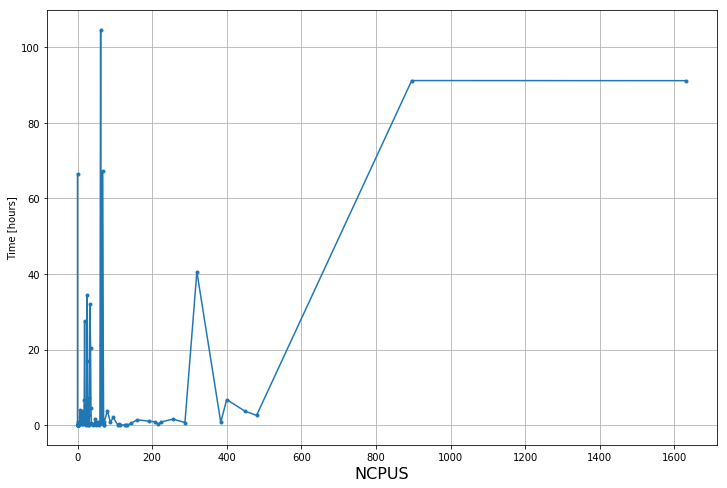

In [10]:
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('111')
ax1.grid()
ax1.set_xlabel('NCPUS', size=16)
ax1.set_ylabel('Time [hours]')
#
ix = numpy.argsort(wait_stats['ncpus'])
ax1.plot(wait_stats['ncpus'][ix], 24.*wait_stats['median'][ix], ls='-', marker='.')

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,0,'time $t$ [hours]')

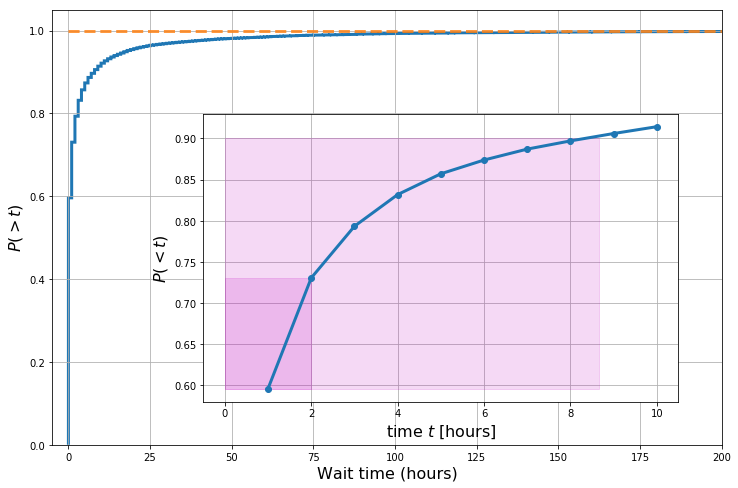

In [11]:
#
delta_ts = 24.*(sacct_obj.jobs_summary['Start'] - sacct_obj.jobs_summary['Submit'])
ix = delta_ts>=0
#
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('111')
ax1.grid()
#
ax2 = fg.add_axes([.3, .2, .55, .5])
ax2.grid()
#
hh = ax1.hist(delta_ts[ix], bins=numpy.arange(0., max(delta_ts[ix]), 1), density=True,
              cumulative=True, histtype='step', lw=3.0)
#
q_90=.9
k_90 = numpy.searchsorted(hh[0], q_90)
#print('*** k90: ', k_90)
x_90 = (hh[1][k_90]*(q_90-hh[0][k_90-1]) + hh[1][k_90+1]*(hh[0][k_90]-q_90))/(hh[0][k_90]-hh[0][k_90-1])

ax1.plot([min([ix][0]), max(delta_ts[ix])], [1., 1.], ls='--', lw=3., alpha=.8)
#
#ax1.set_ylim(.8,1.02)
ax1.set_xlim(-5, 200)
ax1.set_xlabel('Wait time (hours)', size=16)
ax1.set_ylabel('$P(>t)$', size=16)
#
ax2.plot(hh[1][1:11], hh[0][0:10], marker='o', ls='-', lw=3., zorder=12)
ax2.fill_between(hh[1][0:3], numpy.ones(3)*hh[0][1], hh[0][0],
                 color='m', alpha=.15, zorder=11)
#
ax2.fill_between([0,x_90], numpy.ones(2)*q_90, hh[0][0],
                 color='m', alpha=.15, zorder=11)
#
ax2.set_ylabel('$P(<t)$', size=16)
ax2.set_xlabel('time $t$ [hours]', size=16)

In [12]:
print('** 2 hours: ', hh[0][0:2])
print('** 90%: ', x_90)

** 2 hours:  [0.59629082 0.73062608]
** 90%:  8.658324053452116


In [13]:
print('*** ', numpy.mean(sacct_obj.jobs_summary['Elapsed'])*24.)


***  2.8540605105479933


In [14]:
print('*** hh[0]: ', hh[0][0:10])

*** hh[0]:  [0.59629082 0.73062608 0.79331752 0.83178215 0.8570223  0.87373126
 0.88699173 0.89693222 0.90591085 0.91418734]


In [15]:
sacct_obj.__dict__.keys()

dict_keys(['data_file_name', 'delim', 'max_rows', 'types_dict', 'chunk_size', 'n_cpu', 'verbose', 'RH', 'headers', 'raw_data_len', 'data', 'index_job_id', 'ix_user_jobs', 'job_ID_index', 'k', 's', 'jobs_summary', 't_now', 'j_id', 'ks', 'sub_data', 'cpu_usage'])

In [21]:
#sacct_obj.jobs_summary.dtype.names

#
#total_cpu = hpc_lib.elapsed_time_2_day(sacct_obj.jobs_summary['TotalCPU'])*24.
total_cpu = numpy.array([hpc_lib.elapsed_time_2_sec(x) for x in sacct_obj.jobs_summary['TotalCPU']])*24.

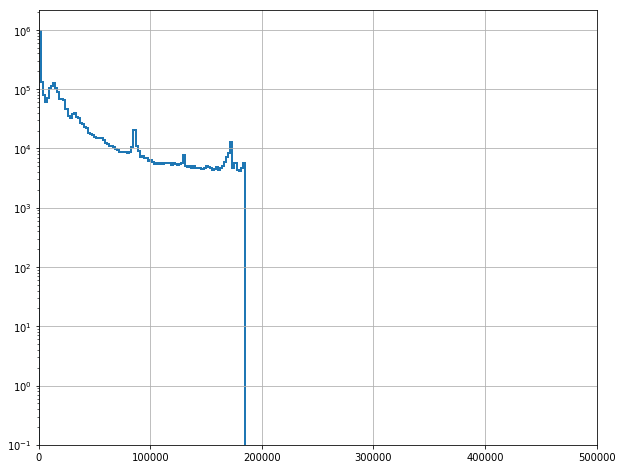

In [27]:
fg = plt.figure(figsize=(10,8))
ax1=plt.subplot('111')
hh=ax1.hist(total_cpu[numpy.logical_and(total_cpu>0., total_cpu<sorted(total_cpu)[int(.8*len(total_cpu))])],
            bins=100, histtype='step', log=True, lw=2)

ax1.set_xlim(-10, 500000)
ax1.grid()


In [19]:
print('** ', total_cpu[0:20])

**  [4147368.    4146768.       5459.544       0.       5465.88  4146792.
 4146648.    4146624.       5518.464    5681.64  4146624.       5664.912
 4146456.    4146528.    4146480.          0.    4143936.    4147080.
 4143720.    4146624.   ]
